In [3]:
# LDA
from gensim import corpora, models
import pyLDAvis.gensim
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric
# Managing data
import pandas as pd
import numpy as np
import re
# DB connection
from scraping import create_connection
# Files & I/O
import pickle
import csv
import os
from pathlib import Path
from io import FileIO
# For logging
import logging
# Plotting
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/mwh/miniconda3/envs/forum/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def write_list(fn, results):
    with open(fn, 'a') as f:
        writer = csv.writer(f) 
        writer.writerow(results)

In [6]:
def load_data(forum="all", group="all", id_type="family_id"):
    lemmatized_text = pickle.load(open(path_lemma_pkl.format(forum, group, id_type), 'rb'))
    corpus = pickle.load(open(path_corpus_pkl.format(forum, group, id_type), 'rb'))
    dictionary = corpora.Dictionary.load(path_dictionary_gensim.format(forum, group, id_type))
    return lemmatized_text, corpus, dictionary

In [7]:
def find_doc_convergence(log, i):
    # Regex to bookend log for iteration - choose last occurrence
    end_slice = re.compile(fr"End of model: {i} iterations")
    end_matches = [end_slice.findall(l) for l in open(log)]
    iteration_end = [i for i, x in enumerate(end_matches) if x]
    iteration_end = iteration_end[-1]
    start_slice = re.compile(fr"Start of model: {i} iterations")
    start_matches = [start_slice.findall(l) for l in open(log)]
    start_options = [i for i, x in enumerate(start_matches) if x]
    start_options = [item for item in start_options if item < iteration_end]
    iteration_start = max(start_options)
    iteration_bookends = [iteration_start, iteration_end]
    # Regex to find documents converged figures
    num = re.compile(":(\d+)\/\d")
    matches_num = [num.findall(l) for l in open(log)]
    matches_num = matches_num[iteration_bookends[0]:iteration_bookends[1]]
    matches_num = [m for m in matches_num if len(m) > 0]
    # Unlist internal lists and turn into numbers
    matches_num = [m for sublist in matches_num for m in sublist]
    matches_num = [float(m) for m in matches_num]
    # Regex to find documents converged figures
    den = re.compile(":\d+\/(\d+)")
    matches_den = [den.findall(l) for l in open(log)]
    matches_den = matches_den[iteration_bookends[0]:iteration_bookends[1]]
    matches_den = [m for m in matches_den if len(m) > 0]
    # Unlist internal lists and turn into numbers
    matches_den = [m for sublist in matches_den for m in sublist]
    matches_den = [float(m) for m in matches_den]
    return(matches_num, matches_den)

In [8]:
p = Path.cwd()
path_parent = p.parents[0]

In [9]:
# database
path_db = str(path_parent / "database" / "youbemom-merged.db")
# data to load
path_lemma_pkl = str(path_parent / "clean_data" / "lemmatized_text_{0}_{1}_{2}.pkl")
path_corpus_pkl = str(path_parent / "clean_data" / "corpus_{0}_{1}_{2}.pkl")
path_dictionary_gensim = str(path_parent / "clean_data" / "dictionary_{0}_{1}_{2}.gensim")
# model saving
path_tune_models = str(path_parent / "clean_data" / "lda_tune_{0}_{1}_{2}_{3}_{4}.gensim")
path_ntopic_models = str(path_parent / "clean_data" / "lda_ntopics_{0}_{1}_{2}_{3}.gensim")
# path_coherence = str(path_parent / "clean_data" / "coherence_{}.csv")
path_log = str(path_parent / "clean_data" / "logging_{0}_{1}_{2}_{3}.log")
path_log_iterations = str(path_parent / "clean_data" / "logging_{0}_{1}_{2}_{3}.log")
# dominant topic
path_dom_topic = str(path_parent / "clean_data" / "dominant_topic_{0}_{1}_{2}_{3}.csv")
# clean text
path_clean_text = str(path_parent / "clean_data" / "clean_text_{0}_{1}.csv")

In [10]:
# subforum = ['special-needs','tween-teen','preschool','elementary','new-york-city','toddler']
subforum = ['school']
group = 'all'
id_type = 'family_id'
n_words = 10
n_passes = 200
n_iterations = [400] # add more to list to test
eval_every = 20
n = 10

In [11]:
for handler in logging.root.handlers:
    logging.root.removeHandler(handler)

In [ ]:
for sf in subforum:
    lemmatized_text, corpus, dictionary = load_data(sf, group, id_type)
    for handler in logging.root.handlers:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=path_log.format(sf, group, id_type, n),
                        format="%(asctime)s:%(levelname)s:%(message)s",
                        level=logging.NOTSET)
    perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
    convergence_logger = ConvergenceMetric(logger='shell')
    coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = lemmatized_text)
    for iterations in n_iterations:
        logging.debug(f'Start of model: {iterations} iterations')
        ldamodel = LdaModel(
            corpus=corpus,
            num_topics=n,
            id2word=dictionary,
            passes=n_passes,
            alpha="auto",
            eta="auto",
            random_state=1,
            iterations=iterations,
            eval_every=eval_every,
            callbacks=[perplexity_logger, convergence_logger, coherence_cv_logger]
        )
        logging.debug(f'End of model: {iterations} iterations')
        ldamodel.save(path_tune_models.format(sf, group, id_type, str(n), str(iterations)))

In [ ]:
sf = subforum[0]
iterations = 400

In [ ]:
ldamodel = LdaModel.load(path_tune_models.format(sf, group, id_type, str(n), str(iterations)))
df = pd.DataFrame.from_dict(ldamodel.metrics)

In [ ]:
plt.plot(df.index, df["Convergence"])
plt.show()

In [ ]:
plt.plot(df.index, df["Coherence"])
plt.show()

In [ ]:
plt.plot(df.index, df["Perplexity"])
plt.show()

In [ ]:
# path_log = str(path_parent / "clean_data" / "logging_tween-teen_all_family_id_10replace.log")

In [ ]:
con_num, con_den = find_doc_convergence(path_log.format(sf, group, id_type, n), 400)

In [ ]:
eval_points = list(range(1)) * 200
epochs = [i for i in range(200) for _ in range(1)]
convergence = pd.DataFrame(list(zip(epochs, eval_points, con_num, con_den)),
                               columns = ["epoch","eval_point","converged","total"])

In [ ]:
convergence['epoch_point'] = convergence['epoch'] + convergence['eval_point'] / 1

In [ ]:
convergence['per_converged'] = convergence['converged'] / convergence['total']

In [ ]:
plt.plot(convergence['epoch_point'], convergence['per_converged'])
plt.show()

In [ ]:
# data for special-needs:
# log: logging_special-needs_all_family_id_10.log
# training model: lda_tune_special-needs_all_family_id_10_200
# topic n models: lda_ntopics_special-needs_all_family_id_{n}
# n_passes = 100
# n_iterations = 200

In [ ]:
# data for tween-teen:
# log: logging_tween-teen_all_family_id_10replace.log
# training model: lda_tune_tween-teen_all_family_id_10_200
# topic n models: lda_ntopics_tween-teen_all_family_id_{n}
# n_passes = 120
# n_iterations = 400

In [ ]:
# data for preschool:
# log: logging_preschool_all_family_id_10replace.log
# training model: lda_tune_preschool_all_family_id_10_200
# topic n models: lda_ntopics_preschool_all_family_id_{n}
# n_passes = 100
# n_iterations = 400

In [ ]:
# data for elementary:
# log: logging_elementary_all_family_id_10replace.log
# training model: lda_tune_elementary_all_family_id_10_200
# topic n models: lda_ntopics_elementary_all_family_id_{n}
# n_passes = 130
# n_iterations = 400

In [ ]:
# data for new-york-city:
# log: logging_new-york-city_all_family_id_10replace.log
# training model: lda_tune_new-york-city_all_family_id_10_200
# topic n models: lda_ntopics_new-york-city_all_family_id_{n}
# n_passes = 150
# n_iterations = 400

In [ ]:
# data for school:
# log: logging_school_all_family_id_10replace.log
# training model: lda_tune_school_all_family_id_10_200
# topic n models: lda_ntopics_school_all_family_id_{n}
# n_passes = 200
# n_iterations = 400

In [14]:
args = {
    'special-needs':{'n_passes':100, 'n_iterations':200, 'n_topics':[5, 10, 15, 20, 25, 30, 40, 50]},
    'tween-teen':   {'n_passes':120, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'preschool':    {'n_passes':100, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30]},
    'elementary':   {'n_passes':130, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30]},
    'new-york-city':{'n_passes':150, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'school':       {'n_passes':200, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'toddler':      {'n_passes':35,  'n_iterations':200, 'n_topics':[5, 10, 15, 20, 25, 30, 40, 50]}
}
# args = {
#     'toddler':      {'n_passes':35,  'n_iterations':200, 'n_topics':[5, 10, 15, 20, 25, 30, 40, 50]}
# }

In [ ]:
for sf, d in args.items():
    print("subforum:", sf)
    n_topics = d['n_topics']
    n_passes = d['n_passes']
    n_iterations = d['n_iterations']
    lemmatized_text, corpus, dictionary = load_data(sf, group, id_type)
    for n in n_topics:
        print("number of topics: ", n)
        ldamodel = LdaModel(
            corpus=corpus,
            num_topics=n,
            id2word=dictionary,
            passes=n_passes,
            alpha="auto",
            eta="auto",
            random_state=1,
            iterations=n_iterations,
            eval_every=eval_every
        )
        ldamodel.save(path_ntopic_models.format(sf, group, id_type, str(n)))

In [ ]:
for sf, d in args.items():
    path_topics = str(path_parent / "clean_data" / "lda_topics_{0}_{1}_{2}.csv")
    write_list(path_topics.format(sf, group, id_type), ["n_topics","topic_n","topics"])
    n_topics = d['n_topics']
    for n in n_topics:
        ldamodel = LdaModel.load(path_ntopic_models.format(sf, group, id_type, str(n)))
        topics = ldamodel.print_topics(num_topics=n, num_words=n_words)
        for topic in topics:
            write_list(path_topics.format(sf, group, id_type), [n, topic[0], topic[1]])

## Compare different number of topics

In [1]:
sf = "special-needs"

In [12]:
lemmatized_text, corpus, dictionary = load_data(sf, group, id_type)

In [15]:
mod_dict = {}
for i in args[sf]["n_topics"]:
    mod_dict[str(i)] = LdaModel.load(path_ntopic_models.format(sf, group, id_type, str(i)))

In [37]:
for _, mod in mod_dict.items():
    coherence_model_lda = CoherenceModel(model=mod, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
    print(coherence_model_lda.get_coherence())
    print()

0.39751689647658994

0.5109493963639747

0.466542260172344

0.45627918369417236

0.4474820446226513

0.44610634482738726

0.41357272644570686

0.3992980744831426



In [14]:
n = 20
pyLDAvis.display(pyLDAvis.gensim.prepare(mod_dict[str(n)], corpus, dictionary, sort_topics=False))

In [ ]:
def cluster_test(corpus, model):
    docs_with_1_topic = 0
    docs_with_multiple_topics = 0
    docs_with_no_topics = 0
    total_docs = 0
    for doc in corpus:
        topics = model.get_document_topics(doc, minimum_probability=0.20)
        total_docs += 1
        if len(topics) == 1:
            docs_with_1_topic += 1
        elif len(topics) > 1:
            docs_with_multiple_topics += 1
        else:
            docs_with_no_topics += 1
    print('Corpus assigned to a single topic:', (docs_with_1_topic / total_docs) * 100, '%')
    print('Corpus assigned to multiple topics:', (docs_with_multiple_topics / total_docs) * 100, '%')
    print('corpus assigned to no topics:', (docs_with_no_topics / total_docs) * 100, '%')

In [ ]:
for _, mod in mod_dict.items():
    cluster_test(corpus, mod)

In [16]:
clean_text = pd.read_csv(path_clean_text.format(sf, group))
clean_text = clean_text[['family_id','text_clean']].groupby(['family_id'])['text_clean'].apply(' '.join)
clean_text = pd.DataFrame(clean_text)
clean_text.reset_index(inplace=True)
clean_text.head()

,family_id,text_clean
0,173,son has mild sensory issuesany privates in man...
1,224,moms of older dc school question our dss behav...
2,358,the asd diagnostic criteria no longer fits my ...
3,616,15 yo has very explosive behavior at home only...
4,914,random question but do you know of friends or ...


In [17]:
n = 20

In [18]:
out = np.zeros((len(corpus), n), dtype=float, order='C')

In [19]:
def gen_cols(n):
    return ["topic_{}".format(str(i).zfill(2)) for i in range(n)]

In [20]:
for i, doc in enumerate(corpus):
    topics = mod_dict[str(n)].get_document_topics(doc)
    for j, score in topics:
        out[i,j] = score

In [21]:
path_topic_counts = str(path_parent / "clean_data" / "topics_{0}_{1}_{2}.csv")
topic_df = pd.concat([clean_text, pd.DataFrame(out, columns=gen_cols(n))], axis=1)
topic_df.to_csv(path_topic_counts.format(sf, group, n))

In [28]:
df = pd.DataFrame(out)

In [32]:
colsums = df.sum()
totalsum = colsums.sum()
100 * colsums / totalsum

0      0.640351
1      0.064437
2     10.804672
3      1.953887
4      0.826421
5      1.825726
6      5.200247
7      2.610185
8      0.118913
9     31.879728
10     9.709148
11     2.449231
12     0.072536
13     0.416947
14     1.068702
15     3.252366
16     1.205917
17     1.198563
18    23.628179
19     1.073845
dtype: float64

In [ ]:
# def format_topics_sentences(ldamodel, corpus):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row in enumerate(ldamodel[corpus]):
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
#     return(sent_topics_df)

## Plot Differences Between Topics

In [15]:
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""
    import plotly.graph_objs as go
    import plotly.offline as py

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))


def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)


try:
    get_ipython()
    import plotly.offline as py
except Exception:
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

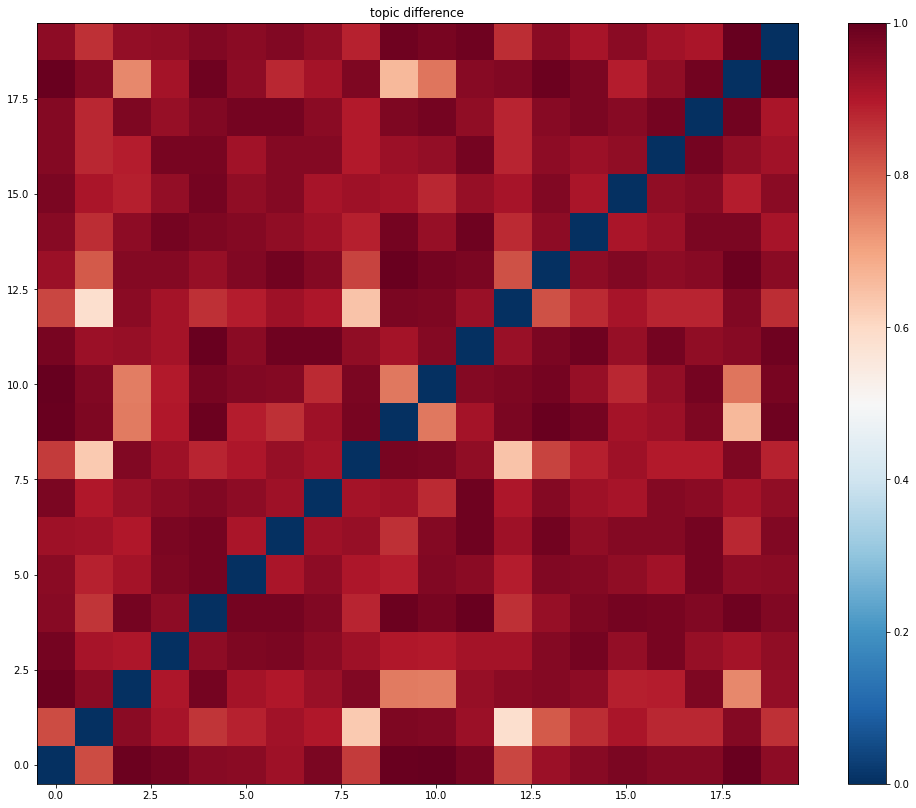

In [18]:
n1 = 20
n2 = 20
mdiff, annotation = mod_dict[str(n1)].diff(mod_dict[str(n2)], distance="hellinger", num_words=50)
plot_difference(mdiff, title="topic difference", annotation=annotation)

## Grid Search (Depreciated)

In [ ]:
# subforums = ['tween-teen','preschool','elementary','new-york-city']
args = {
    'school':       {'n_passes':200, 'n_iterations':400, 'n_topics':[50, 75, 100]}
}

group = "all"
id_type = "family_id"

alpha = [.001, .01, .1, .3, .5, .7, .9, .99, .999]
beta = [.001, .01, .1, .3, .5, .7, .9, .99, .999]

path_tune_abn = str(path_parent / "clean_data" / "abn_tune_{0}_{1}_{2}")

for sf, d in args.items():
    write_list(path_tune_abn.format(sf, group, id_type), ["n","alpha","beta","coherence"])
    n_topics = d['n_topics']
    lemmatized_text, corpus, dictionary = load_data(sf, group, id_type)
    max_coherence = 0
    for n in n_topics:
        for a in alpha:
            for b in beta:
                ldamodel = LdaModel(
                    corpus=corpus,
                    num_topics=n,
                    id2word=dictionary,
                    alpha=a,
                    eta=b,
                    random_state=1
                )
                coherence_model_lda = CoherenceModel(model=ldamodel, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
                coherence = coherence_model_lda.get_coherence()
                print("topics:",n,"alpha:",a,"beta:",b,"coherence:",coherence)
                if max_coherence < coherence:
                    max_coherence = coherence
                    print("new best")
                write_list(path_tune_abn.format(sf, group, id_type), [str(n), str(a), str(b), str(coherence)])